# Parte 1: Estimação do canal

Esse relatório tem como objetivo utilizar as funções de transmissão e os conceitos previamente abordados para fazer a 

O objetivo dessa 

In [1]:
# Bibliotecas numéricas e devisualização de gráficos
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas pessoais para funções itnernas
from TransmissaoDigital.Operations import *
from TransmissaoDigital.Plots import *

Parâmetros iniciais da simulação

In [2]:
M = 16 # Número de antenas
K = 4  # Número de dispositivos

messageLength = 10**5 # Números de símbolos transmitidos por usuário

Definição do canal e do sinal transmitido

In [3]:
def GerarCanal(M,K):
    return np.matrix(np.random.normal(0,1,size=(M,K))+1j*np.random.normal(0,1,size=(M,K)))

def GerarSimbolos(K,tamanhoMensagem):
    return np.matrix(np.random.choice([-1,1],size=(K,tamanhoMensagem)) + 1j * np.random.choice([-1,1],size=(K,tamanhoMensagem)))/np.sqrt(2)

## Investigação atual

Tentou-se aplicar a quantização antes do processamento do sinal mas sem sucesso. Em qlqr SNR o erro era de 100%. Abaixo está a tentativa de implementar a estimação do sinal proposta no artigo para que ela utilize os receptores ZF e MRC pra ver se algum gráfico pertinente de BER sai disso. 

Métodos de estimação implementados:
* `EstimarCanalMS`: MS simples
* `EstimarCanalAQN`: Additive quantizer noise (Proposta de \[28\]) (É o bussgang para $\tau=K$)
* `EstimarCanalBussgang`: Bussgang ($\tau^{\text{OPT}}$)

Verificar: 
* Cálculo da matriz de autocorrelação de $R_p$
* Calculo do MSE normalizado

Implementar:
* Cálculo da eficiência espectral de cada método
* Cálculo do BER alcançado pelos val

In [4]:
def Vect(Matriz):
    return Matriz.ravel(order='F')

In [5]:
def AutoCorr(vector):
    
    vectorSize = vector.shape[0]
    fullData = np.concatenate([vector[::-1][:-1],vector])
    
    res = np.zeros((vectorSize,vectorSize),dtype='complex')
    #print(fullData)
    for idx in range(vectorSize):
        #print(f"i:{i} / vectorSize-i: {vectorSize-i}")
        res[vectorSize-idx-1,:] = fullData[idx:vectorSize+idx]
    
    return res

In [6]:
def EstimarCanalBussgang(H_real,tamanhoPiloto=None,SNR=20):
    """
    EstimarCanalBussgang(H_real)
    Descrição:
        Estima o canal e retorna um canal estimado
    Parametros:
        - H_real: Canal real
        - tamanhoPiloto (default=None): Quantidade de símbolos piloto 
        para transmissão. Se vazio, considera igual ao número de antenas
        definido por H_real.
        - SNR (default=20): SNR do treinamento, em dB
    Return:
        - H_est: Canal estimado
    """
    K = H_real.shape[1]
    M = H_real.shape[0]
    
    if not tamanhoPiloto:
        tamanhoPiloto = K
    
    rho_d = np.sqrt(10**(SNR/20))
    
    # Cria matriz piloto segundo especificações
    pilotos = np.fft.fft(np.eye(max(tamanhoPiloto,K)))
    Phi = pilotos[0:tamanhoPiloto,0:K] 
    
    Ap = np.sqrt((2/np.pi)*(1/(K*rho_d+1)))*np.eye(M*tamanhoPiloto)
    
    Phi_bar = np.kron(Phi,rho_d*np.eye(M))
    
    Phi_tilde = np.matrix(np.matmul(Ap,Phi_bar))
    #print(M*tamanhoPiloto)
    #print(Phi_tilde.shape)
    
    #print(H_real.shape)
    #print(Phi.shape)
    Y_rec = TransmissaoMIMO(H_real,Phi.T,SNR=SNR)
    R_rec = Quantizador(Y_rec)
    
    R_rec = np.ravel(R_rec,order='F')
    
    #
    # PROBLEMA ATUAL: O calculo da matriz de autocorrelacao de R_p
    #  - Talvez tenha a solução: https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
    #
    #
    
    Corr_R = AutoCorr(R_rec)
    H_est = np.matmul(Phi_tilde.H,np.linalg.inv(Corr_R))
    H_est = np.matmul(H_est,R_rec)
    
    return H_est.reshape(H_real.shape,order='F')

In [7]:
def EstimarCanalAQN(H_real,SNR=20):
    """
    EstimarCanalBussgang(H_real)
    Descrição:
        Estima o canal e retorna um canal estimado
    Parametros:
        - H_real: Canal real
        - tamanhoPiloto (default=None): Quantidade de símbolos piloto 
        para transmissão. Se vazio, considera igual ao número de antenas
        definido por H_real.
        - SNR (default=20): SNR do treinamento, em dB
    Return:
        - H_est: Canal estimado
    """
    # Obtenção dos parâmetros importantes
    K = H_real.shape[1]
    M = H_real.shape[0]
    tamanhoPiloto = K
    
    # Cria matriz piloto segundo especificações
    pilotos = np.fft.fft(np.eye(max(tamanhoPiloto,K)))
    Phi = pilotos[0:tamanhoPiloto,0:K] 
    
    # Calcula matriz Ap da decomposicao
    rho_d = np.sqrt(10**(SNR/20))
    Ap = np.sqrt((2/np.pi)*(1/(K*rho_d+1)))*np.eye(M*tamanhoPiloto)
    
    # Calcula a relação de equação
    Phi_bar = np.kron(Phi,rho_d*np.eye(M))
    Phi_tilde = np.matrix(np.matmul(Ap,Phi_bar))
    
    # Faz a transmissão no canal e quantiza o resultado
    Y_rec = TransmissaoMIMO(H_real,Phi.T,SNR=SNR)
    R_rec = Quantizador(Y_rec)
    R_rec = np.ravel(R_rec,order='F')
    
    # Calcula o estimador
    H_est = np.matmul(Phi_tilde.H,R_rec)
    
    return H_est.reshape(H_real.shape,order='F')

In [8]:
def EstimarCanalMS(H_real,tamanhoPiloto=None,SNR=20,quant=True):
    
    # Define tamanho do 
    if not tamanhoPiloto:
        tamanhoPiloto = K
        
    Rho_p = np.sqrt(10**(SNR/20))
    
    pilotos = np.fft.fft(np.eye(max(tamanhoPiloto,K)))
    Phi = pilotos[0:tamanhoPiloto,0:K] 
    
    Y_rec = TransmissaoMIMO(H_real,Phi.T,SNR=SNR)
    if quant:
        Y_rec = Quantizador(Y_rec)
    
    Phi_bar = np.kron(Phi,Rho_p*np.eye(M))
    
    H_est = np.linalg.lstsq(Phi_bar,Vect(Y_rec).T,rcond=None)[0]
    
    return H_est.reshape(H_real.shape,order="F")

## Cálculo do erro médio quadrático da estimação de canal

Nessa seção, será feito o uso das funções `EstimarCanalMS` e `EstimarCanalBussgang` para fazer a estimativa de canal. 

O cálculo do erro médio quadrático é feito por SNR. Para cada SNR, serão feitas `repeticoes` repetições do seguinte experimento:
1. Calcula-se matrizes para canal real (`H_real`) e pilotos (`Phi`)
2. Faz-se a estimação do canal para cada um dos métodos (`H_est`). São eles
    * Mínimos Quadrados: `EstimarCanalMS`
    * Bussgang (modelo proposto): `EstimarCanalBussgang`
3. Calcula-se o erro médio quadrático entre `H_real` e `H_est`.
4. Salva os resultados.

In [9]:
repeticoes = 100 # Número de repetições por SNR

M = 16
K = 4

resultados = pd.DataFrame(columns=['estimador','SNR','NMSE (dB)'])

def CalculateNMSE(H_est,H_real):
    return 20*np.log10(
        np.sum(
            np.square(np.abs(Vect(H_est) - Vect(H_real)))/np.square(H_real.shape[0]*H_real.shape[1])
        )
    )

for SNR in range(-30,35,5): # Verifica entre -20 e 20 dB
    
    for i in range(repeticoes):
        H_real = GerarCanal(M,K) # Gera canal
        
        # Estima o canal
        H_est_MS = EstimarCanalMS(H_real,SNR=SNR)
        H_est_AQN = EstimarCanalAQN(H_real,SNR=SNR)
        H_est_Buss = EstimarCanalBussgang(H_real,tamanhoPiloto=20,SNR=SNR)
        
        # Calcula o resultado e adiciona a tabela
        data = {
            'estimador':['MS',"AQN","Bussgang"],
            'SNR':[SNR,SNR,SNR],
            'NMSE (dB)':[
                CalculateNMSE(H_est_MS,H_real),
                CalculateNMSE(H_est_AQN,H_real),
                CalculateNMSE(H_est_Buss,H_real)
            ]   
        }
        
        resultados = pd.concat([resultados,pd.DataFrame(data)],ignore_index=True)

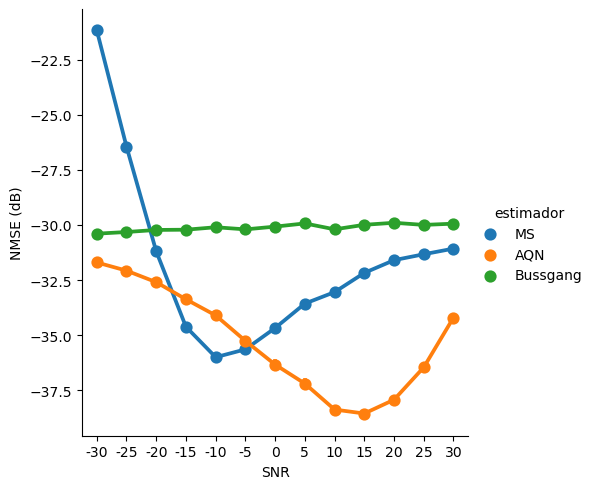

In [10]:
sns.catplot(data=resultados,x='SNR',y='NMSE (dB)',hue='estimador',errorbar="se",kind="point")

(4, 100000)
(16, 100000)
(4, 16)


ValueError: Masked arrays must be 1-D

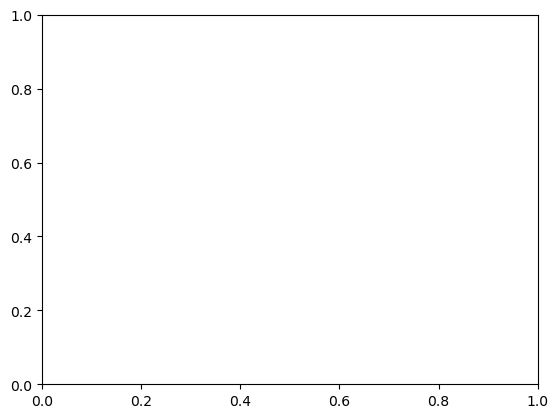

In [21]:
s = GerarSimbolos(K,messageLength)
print(s.shape)
Y = TransmissaoMIMO(H_real,s)
#Y = Quantizador(Y)
print(Y.shape)
H_est = EstimarCanalMS(np.matrix(H_real))
W = ReceptorMRC(H_real)
print(W.shape)
s_est=W@Y
PlotConstelacao(np.matrix(s_est))
s_est = Quantizador(s_est)
print(s_est.shape)
BER = (np.sum(np.abs(s_est - s) > 10**(-4)))/(s_est.shape[0]*s_est.shape[1])
BER

## Estimação por MS

In [12]:
a = np.array([1,2,3,1,2,3])

np.outer(a,a)

array([[1, 2, 3, 1, 2, 3],
       [2, 4, 6, 2, 4, 6],
       [3, 6, 9, 3, 6, 9],
       [1, 2, 3, 1, 2, 3],
       [2, 4, 6, 2, 4, 6],
       [3, 6, 9, 3, 6, 9]])